# Lithographic wells corrugations model

In [1]:
# calcolates simple matrix for mapping clusters colloids into primitive cell and viceversa.
def calc_matrices_square(R):
    area  = R*R
    u     = np.array([[1,0], [0,1]])*R/area
    u_inv = np.array([[1,0], [0,1]])*R
    return u, u_inv

def calc_matrices_triangle(R):
#     area  = R*R*sqrt(3)/2
#     u     = np.array([[1,0], [-1./2, sqrt(3)/2]])*R/area
#     u_inv = np.array([[sqrt(3)/2,0], [1/2,1]])*R
    
    area = R*R*np.sqrt(3)/2.
    u =     np.array([[np.sqrt(3)/2.,0.5], [0,1]])*R/area
    u_inv = np.array([[1,-0.5],[0.0, np.sqrt(3)/2.]])*R
    return u, u_inv

def sub_en(pos, a, b, ww, epsilon, u, u_inv):
    en = np.zeros(pos.shape[0])
    # map to substrate cell
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    # energy inside flat bottom region
    en[R <= a] = -epsilon
    # colloids inside the curve region
    # mask and relative R
    inside = np.logical_and(R<b, R>a)
    Xin = X[inside]
    Yin = Y[inside]
    Rin = R[inside]
    # calculation of energy and force
    # See X. Cao Phys. Rev. E 103, 1 (2021)
    xx = (Rin-a)/(b-a) # Reduce coordinate rho in [0,1]
    # energy
    en[inside] = epsilon/2.*(np.tanh((xx-ww)/xx/(1-xx))-1.)
    return en

def sub_force(pos, a, b, ww, epsilon, u, u_inv):
    Fx = np.zeros(pos.shape[0])
    Fy = np.zeros(pos.shape[0])
    # map to substrate cell
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    # colloids inside the curve region
    # mask and relative R
    inside = np.logical_and(R<b, R>a)
    Xin = X[inside]
    Yin = Y[inside]
    Rin = R[inside]
    # calculation of energy and force
    # See X. Cao Phys. Rev. E 103, 1 (2021)
    xx = (Rin-a)/(b-a) # Reduce coordinate rho in [0,1]
    # force F = - grad(E)
    ff = (xx-ww)/xx/(1-xx)
#     ass = (np.cosh(ff)*(xx-1)*xx)*(np.cosh(ff)*(xx-1)*xx)
    ass = (np.cosh(ff)*(1-xx)*xx)*(np.cosh(ff)*(1-xx)*xx)
    vecF = -epsilon/2*(xx*xx+ww-2*ww*xx)/ass
    # Go from rho to r again, no?
    vecF /= (b-a)
    # AS to EP: Why multiply for x/r?
    Fx[inside] = vecF*Xin/Rin
    Fy[inside] = vecF*Yin/Rin
    return Fx, Fy

In [40]:
# R, a, b = 5, 0.6, 2
R, a, b = 4.45, 0.6, 2
epsilon, wd = 1, 0.29
u, u_inv = calc_matrices_square(R)
# u, u_inv = calc_matrices_triangle(R)

print(u)
print(u_inv)
print(np.linalg.inv(u))
inputs = [a, b, wd, epsilon, u, u_inv]

side, dens = 5.2, 500
xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
pos = np.array([[x,y] for x in xx for y in yy])
print(xx.shape, pos.shape)

[[0.2247191 0.       ]
 [0.        0.2247191]]
[[4.45 0.  ]
 [0.   4.45]]
[[4.45 0.  ]
 [0.   4.45]]
(1000,) (1000000, 2)


/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply


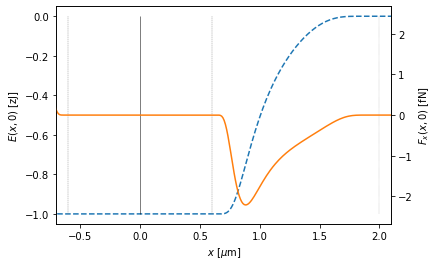

In [41]:
xline = np.array([[x,0] for x in xx])

plt.plot(xline[:,0], sub_en(xline, *inputs), '--')
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$E(x, 0)$ [zJ]")

axt = plt.gca().twinx()
Fx, Fy = sub_force(xline, *inputs)

axt.plot(xline[:,0], Fx, '-', color='tab:orange')
axt.set_ylabel(r"$F_x(x, 0)$ [fN]")

plt.xlim([-0.7,2.1])
xlim = plt.xlim()
ylim = plt.ylim()
plt.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
plt.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.xlim(xlim)

plt.show()

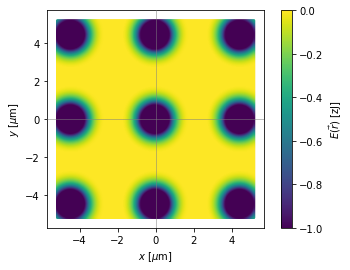

In [42]:
sc = plt.scatter(pos[:,0], pos[:,1], c=sub_en(pos, *inputs), s=0.05)
cbar = plt.colorbar(sc)
cbar.set_label(r'$E(\vec{r})$ [zJ]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')

On R 4.0


/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh


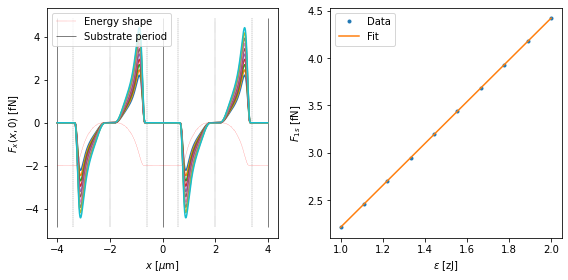

Slope 2.20981
Xmin= -0.88 ± 0.00
-----------------------------------------
On R 4.666666666666667


/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: o

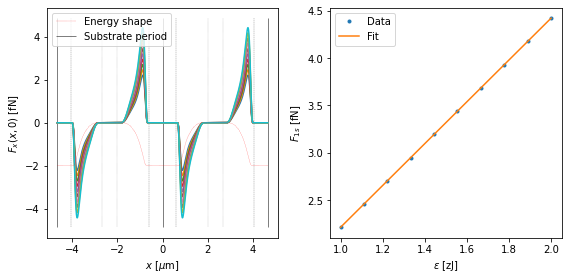

Slope 2.20981
Xmin= 3.78 ± 0.00
-----------------------------------------
On R 5.333333333333333


/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encounte

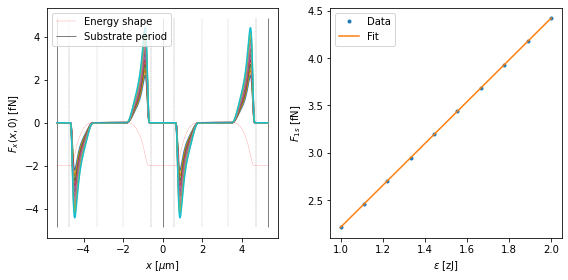

Slope 2.20977
Xmin= -0.88 ± 0.00
-----------------------------------------
On R 6.0


/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh


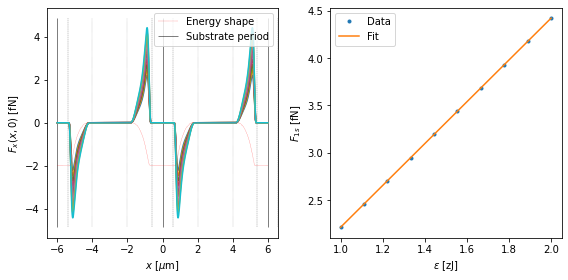

Slope 2.20981
Xmin= 5.12 ± 0.00
-----------------------------------------


In [5]:
R_list = np.linspace(4, 6, 4)
# R_list = np.array([4.45])
F_max = np.zeros(R_list.shape)

for i, R in enumerate(R_list):
    print("On R", R)
    eps_list = np.linspace(1, 2, 10)
    F_max = np.zeros(eps_list.shape)
    xF_max = np.zeros(eps_list.shape)
    u, u_inv = calc_matrices_triangle(R)
    
    fig, (ax_f, ax_scaling) = plt.subplots(1,2, figsize=(8,4))
    
    for ei, epsilon in enumerate(eps_list):
#         print("Epsilon", epsilon)
        inputs = [a, b, wd, epsilon, u, u_inv]

        side, dens = R, 2000
        xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
        xline = np.array([[x,0] for x in xx])
        
        Fx, Fy = sub_force(xline, *inputs)
        F_max[ei] = np.max(Fx)
        xF_max[ei] = xline[np.argmax(Fx)][0]
        ax_f.plot(xline[:,0], Fx, '-',)
    
    Fx, Fy = sub_force(xline, *inputs)
    ax_f.plot(xline[:,0], sub_en(xline, *inputs), ':', color="red", lw=0.4, label="Energy shape")
    ax_f.set_ylabel(r"$F_x(x, 0)$ [fN]")
    ax_f.set_xlabel(r"$x$ [$\mu$m]")

    # Highlight substrate periodicity
    xlim = ax_f.get_xlim()
    ylim = ax_f.get_ylim()
    ax_f.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
    ax_f.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.set_xlim(xlim)
    ax_f.legend()

    ax_scaling.plot(eps_list, F_max, '.', label='Data')
    # plt.gca().set_aspect('equal')

    from numpy.polynomial import polynomial as P
    c = P.polyfit(eps_list,F_max,1)
    cpoly = np.poly1d(c)
    ax_scaling.plot(eps_list, c[1]*eps_list, '-', label='Fit')
    ax_scaling.set_xlabel(r"$\epsilon$ [zJ]")
    ax_scaling.set_ylabel(r"$F_{1s}$ [fN]")
    ax_scaling.legend()
    
    plt.tight_layout()
    plt.show()

#     plt.plot(eps_list, xF_max, ':')
    print("Slope %.5f" % c[1])
    print("Xmin= %.2f ± %.2f" % (np.mean(xF_max),np.std(xF_max)))
#     plt.show()
    print('-----------------------------------------')

So $F_{1s} = 2.2097667346858523 \epsilon$, which is the solution in the reduce coordinates of the Cosh trascendental equation. Varies with $w_d$ of course.

For the whole commensurate cluster, multiply by the number of colloids:

In [6]:
c[1]

2.2098118270421536

In [7]:
N = 7
print("F1s=%.4f fN" % (N*c[1]))

F1s=15.4687 fN


# Gaussian model



In [8]:
def en_gaussian(pos, sigma, epsilon, u, u_inv):
    en = np.zeros(pos.shape[0])
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    off = R != 0
    en[off] = epsilon*gaussian(R[off], 0, sigma)
    return en

def F_gaussian(pos, sigma, epsilon, u, u_inv):
    Fx = np.zeros(pos.shape[0])
    Fy = np.zeros(pos.shape[0])
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    off = R != 0
    Fx[off] = -epsilon*gaussian(R[off],0,sigma) * (R[off] / np.power(sigma, 2.)) * X[off] / R[off]
    Fy[off] = -epsilon*gaussian(R[off],0,sigma) * (R[off] / np.power(sigma, 2.)) * Y[off] / R[off]
    return [Fx, Fy]

def gaussian(x, mu, sig):
    return -np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / (2. * np.pi * np.power(sig, 2.))


In [35]:
R, sigma = 4.45*sqrt(7)/2, 0.6
epsilon = 1
# u, u_inv = calc_matrices_square(R)
u, u_inv = calc_matrices_triangle(R)

print(u)
print(u_inv)
print(np.linalg.inv(u))
inputs = [sigma, epsilon, u, u_inv]

side, dens = 5.2, 200
xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
pos = np.array([[x,y] for x in xx for y in yy])
print(xx.shape, pos.shape)

[[0.16987167 0.09807546]
 [0.         0.19615091]]
[[ 5.88679667 -2.94339833]
 [ 0.          5.09811546]]
[[ 5.88679667 -2.94339833]
 [ 0.          5.09811546]]
(200,) (40000, 2)


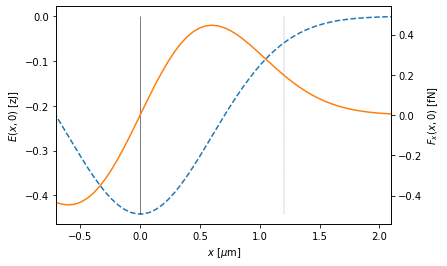

In [36]:

xline = np.array([[x,0] for x in xx])

a, b = 2*sigma, 4*sigma

plt.plot(xline[:,0], en_gaussian(xline, *inputs), '--')
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$E(x, 0)$ [zJ]")


axt = plt.gca().twinx()
Fx, Fy = F_gaussian(xline, *inputs)

axt.plot(xline[:,0], Fx, '-', color='tab:orange')
axt.set_ylabel(r"$F_x(x, 0)$ [fN]")

plt.xlim([-0.7,2.1])
xlim = plt.xlim()
ylim = plt.ylim()
plt.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
plt.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.xlim(xlim)

plt.show()

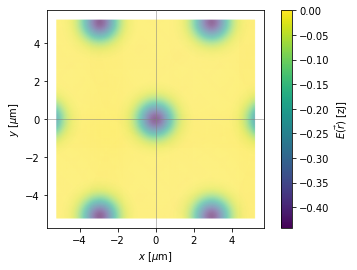

In [37]:
sc = plt.scatter(pos[:,0], pos[:,1], c=en_gaussian(pos, *inputs), s=0.05)
cbar = plt.colorbar(sc)
cbar.set_label(r'$E(\vec{r})$ [zJ]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')

On R 4.0


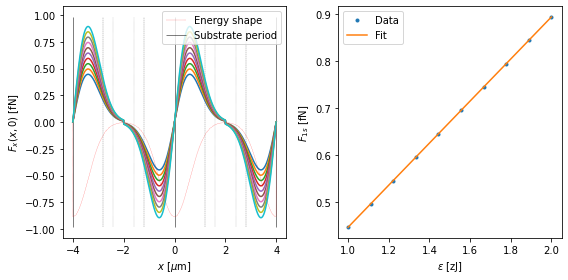

Slope 0.44691
Xmin= -3.40 ± 0.00
-----------------------------------------
On R 4.666666666666667


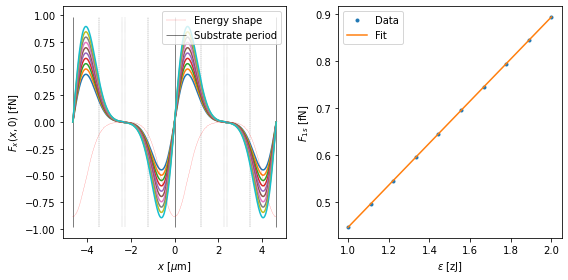

Slope 0.44691
Xmin= 0.60 ± 0.00
-----------------------------------------
On R 5.333333333333333


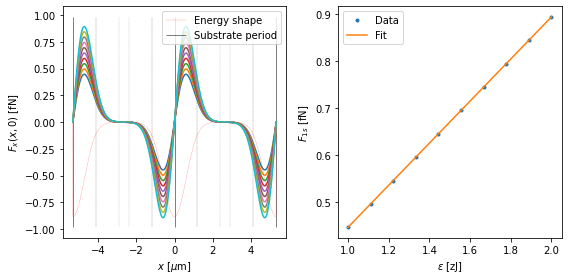

Slope 0.44691
Xmin= 0.60 ± 0.00
-----------------------------------------
On R 6.0


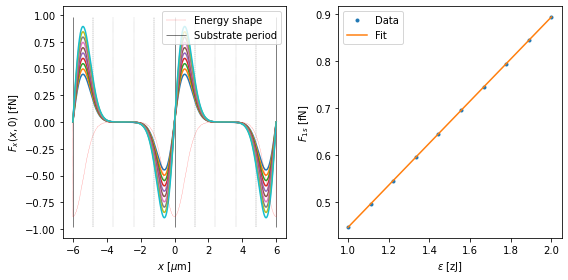

Slope 0.44691
Xmin= -5.40 ± 0.00
-----------------------------------------


In [24]:
R_list = np.linspace(4, 6, 4)
# R_list = np.array([4.45])
F_max = np.zeros(R_list.shape)

for i, R in enumerate(R_list):
    print("On R", R)
    eps_list = np.linspace(1, 2, 10)
    F_max = np.zeros(eps_list.shape)
    xF_max = np.zeros(eps_list.shape)
    u, u_inv = calc_matrices_triangle(R)
    
    fig, (ax_f, ax_scaling) = plt.subplots(1,2, figsize=(8,4))
    
    for ei, epsilon in enumerate(eps_list):
#         print("Epsilon", epsilon)
        inputs = [sigma, epsilon, u, u_inv]

        side, dens = R, 2000
        xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
        xline = np.array([[x,0] for x in xx])
        
        Fx, Fy = F_gaussian(xline, *inputs)
        F_max[ei] = np.max(Fx)
        xF_max[ei] = xline[np.argmax(Fx)][0]
        ax_f.plot(xline[:,0], Fx, '-',)
    
    Fx, Fy = F_gaussian(xline, *inputs)
    ax_f.plot(xline[:,0], en_gaussian(xline, *inputs), ':', color="red", lw=0.4, label="Energy shape")
    ax_f.set_ylabel(r"$F_x(x, 0)$ [fN]")
    ax_f.set_xlabel(r"$x$ [$\mu$m]")

    # Highlight substrate periodicity
    xlim = ax_f.get_xlim()
    ylim = ax_f.get_ylim()
    ax_f.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
    ax_f.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.set_xlim(xlim)
    ax_f.legend()

    ax_scaling.plot(eps_list, F_max, '.', label='Data')
    # plt.gca().set_aspect('equal')

    from numpy.polynomial import polynomial as P
    c = P.polyfit(eps_list,F_max,1)
    cpoly = np.poly1d(c)
    ax_scaling.plot(eps_list, c[1]*eps_list, '-', label='Fit')
    ax_scaling.set_xlabel(r"$\epsilon$ [zJ]")
    ax_scaling.set_ylabel(r"$F_{1s}$ [fN]")
    ax_scaling.legend()
    
    plt.tight_layout()
    plt.show()

#     plt.plot(eps_list, xF_max, ':')
    print("Slope %.5f" % c[1])
    print("Xmin= %.2f ± %.2f" % (np.mean(xF_max),np.std(xF_max)))
#     plt.show()
    print('-----------------------------------------')

In [25]:
c[1]

0.4469089281335388

So $F_{1s} = 0.4469089281335388 \epsilon$, which is the solution in the reduce coordinates of the Cosh trascendental equation. Varies with $w_d$ of course.

For the whole commensurate cluster, multiply by the number of colloids:

In [26]:
N = 7
print("F1s=%.4f fN" % (N*c[1]))

F1s=3.1284 fN
